# Conditional TimeGrad Demo

This notebook is a reproducible, end-to-end walkthrough of the conditional TimeGrad pipeline:

1. Load and preprocess the parquet datasets.
2. Inspect processed features for targets, dynamic, and static conditioning signals.
3. Build the conditioning-aware TimeGrad training and prediction networks.
4. Train for a few quick epochs (demo-friendly) with causal cross-attention and FiLM conditioning enabled.
5. Generate hundreds of scenario samples autoregressively.
6. Visualize raw prices, forecast mean/quantiles, individual scenario paths, and compare to ground truth.
7. Compute CRPS, MAE, and coverage metrics while highlighting conditioning effects.


In [5]:
# Imports + Config
import math
from pathlib import Path
import numpy as np
import pandas as pd
import torch
from torch import nn
import matplotlib.pyplot as plt
import seaborn as sns
import sys
import os

try:
    # Assumes notebook is in a subdirectory (e.g., /notebooks)
    project_root = Path(__file__).resolve().parents[1]
except NameError:
    # Fallback for interactive environments (like Jupyter)
    project_root = Path(os.getcwd()).resolve().parent

if str(project_root) not in sys.path:
    sys.path.insert(0, str(project_root))

print(f"Project Root: {project_root}")

from src import config
from src.data_loader import TimeGradDataModule
from src.training import ConditionalTimeGradTrainingNetwork
from src.predictor import ConditionalTimeGradPredictionNetwork

plt.style.use('seaborn-v0_8-darkgrid')

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Using device: {device}")

# Demo-friendly hyperparameters
context_length = 64
prediction_length = 24
batch_size = 4
num_epochs = 2  # keep small for a quick run
max_train_steps = 4
max_val_steps = 2
num_samples = 200  # scenario samples
lr = 1e-3


Project Root: /workspaces/My_Little_Quant_Firm/FinD_Generator
Using device: cpu


In [6]:
# Load & preprocess data
# MODIFICATION: Define the base path for data relative to the project_root
data_base = project_root / 'data'
raw_base = data_base / 'raw'
raw_paths = {
    'target': raw_base / 'target.parquet',
    'market': raw_base / 'market.parquet',
    'daily_macro': raw_base / 'daily_macro.parquet',
    'monthly_macro': raw_base / 'monthly_macro.parquet',
    'quarterly_macro': raw_base / 'quarterly_macro.parquet',
}

data_dict = {name: pd.read_parquet(path) for name, path in raw_paths.items()}
print({k: v.shape for k, v in data_dict.items()})

dm = TimeGradDataModule(
    data_dict=data_dict,
    seq_len=context_length,
    forecast_horizon=prediction_length,
    batch_size=batch_size,
    device=str(device),
)

dm.preprocess_and_split()
dm.build_datasets()


{'target': (7052, 6), 'market': (7052, 6), 'daily_macro': (7305, 3), 'monthly_macro': (336, 5), 'quarterly_macro': (112, 6)}
🔧 [Init] Aligning and preparing macroeconomic data...
align_and_handle_missing_values: daily_df columns before processing: ['Date', 'yield_curve', 'vix']
align_and_handle_missing_values: daily_aligned columns after processing: ['yield_curve_daily', 'vix_daily']
✅ [Init] Macro data alignment complete.

build_raw_blocks: daily_macro_indexed columns before calling process_daily_macro_raw: ['yield_curve_daily', 'vix_daily']
🔄 [build_raw_blocks] Processing raw data blocks...
✅ Target wavelet denoising complete.
✅ Market log-returns computed.
✅ Daily macro block processed.
✅ Monthly macro transformations complete.
✅ Quarterly macro transformations complete.
🏗️ [build_raw_blocks] All raw data blocks prepared.

🔄 [preprocess_raw_merge] Merging all blocks into unified DataFrame...
✅ All blocks merged successfully.
🔄 Adding calendar and regime features...
✅ Calendar featur

(<src.data_loader.ConditionalTimeGradDataset at 0x721ff8d2c0e0>,
 <src.data_loader.ConditionalTimeGradDataset at 0x721ff8b62660>)

In [8]:
# Inspect processed features
feature_cols = dm.get_feature_columns_by_type()
print('Feature columns by type:')
for k, v in feature_cols.items():
    print(f"- {k}: {v}")

sample_batch = next(iter(dm.train_dataloader()))
print('Batch keys:', sample_batch.keys())
for k, v in sample_batch.items():
    print(f"{k}: shape={tuple(v.shape)}")


Feature columns by type:
- target: ['target_pca_1']
- daily: ['market_pca_1', 'market_pca_2', 'market_pca_3', 'daily_vix_daily_scaled', 'daily_yield_curve_daily_scaled', 'volume_scaled', 'day_of_week', 'month', 'quarter', 'year', 'is_month_end', 'is_quarter_end', 'month_sin', 'month_cos', 'dow_sin', 'dow_cos', 'quarter_sin', 'quarter_cos']
- monthly: ['monthly_pca_1', 'monthly_pca_2', 'monthly_pca_3', 'monthly_pca_4']
- regime: ['market_regime_bear', 'market_regime_bull', 'market_regime_sideways', 'vol_regime_high_vol', 'vol_regime_normal_vol', 'macro_regime_normal']
Batch keys: dict_keys(['x_future', 'x_hist', 'cond_dynamic', 'cond_static'])
x_future: shape=(4, 24, 1)
x_hist: shape=(4, 64, 1)
cond_dynamic: shape=(4, 64, 22)
cond_static: shape=(4, 6)


In [9]:
# Build model (training + prediction networks)
target_dim = len(feature_cols['target'])
cond_dynamic_dim = len(feature_cols['daily']) + len(feature_cols['monthly'])
cond_static_dim = len(feature_cols['regime'])

train_net = ConditionalTimeGradTrainingNetwork(
    target_dim=target_dim,
    context_length=context_length,
    prediction_length=prediction_length,
    cond_dynamic_dim=cond_dynamic_dim,
    cond_static_dim=cond_static_dim,
    diff_steps=100,
    beta_end=0.1,
    beta_schedule='linear',
    residual_layers=6,
    residual_channels=32,
    cond_embed_dim=64,
    cond_attn_heads=4,
    cond_attn_dropout=0.1,
).to(device)

predictor = ConditionalTimeGradPredictionNetwork(
    target_dim=target_dim,
    context_length=context_length,
    prediction_length=prediction_length,
    cond_dynamic_dim=cond_dynamic_dim,
    cond_static_dim=cond_static_dim,
    diff_steps=100,
    beta_end=0.1,
    beta_schedule='linear',
    residual_layers=6,
    residual_channels=32,
    cond_embed_dim=64,
    cond_attn_heads=4,
    cond_attn_dropout=0.1,
).to(device)

optimizer = torch.optim.Adam(train_net.parameters(), lr=lr)


In [10]:
# Training loop (fast demo)
train_net.train()
for epoch in range(num_epochs):
    running = 0.0
    for step, batch in enumerate(dm.train_dataloader()):
        x_hist = batch['x_hist'].to(device)
        x_future = batch['x_future'].to(device)
        cond_dynamic = batch['cond_dynamic'].to(device)
        cond_static = batch['cond_static'].to(device)

        optimizer.zero_grad()
        loss = train_net(x_hist, x_future, cond_dynamic, cond_static)
        loss.backward()
        torch.nn.utils.clip_grad_norm_(train_net.parameters(), max_norm=1.0)
        optimizer.step()

        running += loss.item()
        if max_train_steps and (step + 1) >= max_train_steps:
            break
    avg = running / max(1, step + 1)

    # quick val
    train_net.eval()
    val_running = 0.0
    with torch.no_grad():
        for v_step, batch in enumerate(dm.val_dataloader()):
            x_hist = batch['x_hist'].to(device)
            x_future = batch['x_future'].to(device)
            cond_dynamic = batch['cond_dynamic'].to(device)
            cond_static = batch['cond_static'].to(device)
            val_running += train_net(x_hist, x_future, cond_dynamic, cond_static).item()
            if max_val_steps and (v_step + 1) >= max_val_steps:
                break
    val_avg = val_running / max(1, v_step + 1)
    print(f"Epoch {epoch+1}: train_loss={avg:.4f}, val_loss={val_avg:.4f}")
    train_net.train()

# sync weights to predictor for inference
predictor.load_state_dict(train_net.state_dict(), strict=False)


Epoch 1: train_loss=0.5545, val_loss=0.3512
Epoch 2: train_loss=0.5175, val_loss=0.6517


<All keys matched successfully>

In [11]:
# Generate scenario samples
test_batch = next(iter(dm.test_dataloader()))
x_hist = test_batch['x_hist'].to(device)
cond_dynamic = test_batch['cond_dynamic'].to(device)
cond_static = test_batch['cond_static'].to(device)

predictor.eval()
with torch.no_grad():
    samples = predictor.sample_autoregressive(
        x_hist=x_hist,
        cond_dynamic=cond_dynamic,
        cond_static=cond_static,
        num_samples=num_samples,
    )

print('Samples shape:', samples.shape)  # [num_samples, batch, horizon, target_dim]


Samples shape: torch.Size([200, 4, 24, 1])


In [13]:
# Evaluate metrics and summarize

def sample_crps(samples: torch.Tensor, target: torch.Tensor) -> float:
    # samples: [S, B, T, D], target: [B, T, D]
    s1 = (samples - target).abs().mean(dim=0)
    s2 = (samples.unsqueeze(0) - samples.unsqueeze(1)).abs().mean(dim=(0,1))
    return (s1 - 0.5 * s2).mean().item()

first_batch_target = test_batch['x_future'].to(device)
mean_forecast = samples.mean(dim=0)
quantiles = torch.quantile(samples, torch.tensor([0.1, 0.5, 0.9], device=device), dim=0)

mae = (mean_forecast - first_batch_target).abs().mean().item()
coverage = ((first_batch_target >= quantiles[0]) & (first_batch_target <= quantiles[-1])).float().mean().item()
crps = sample_crps(samples, first_batch_target)

print(f"MAE: {mae:.4f} / CRPS: {crps:.4f} / 80% coverage: {coverage:.3f}")

MAE: 0.0433 / CRPS: 0.0344 / 80% coverage: 0.167


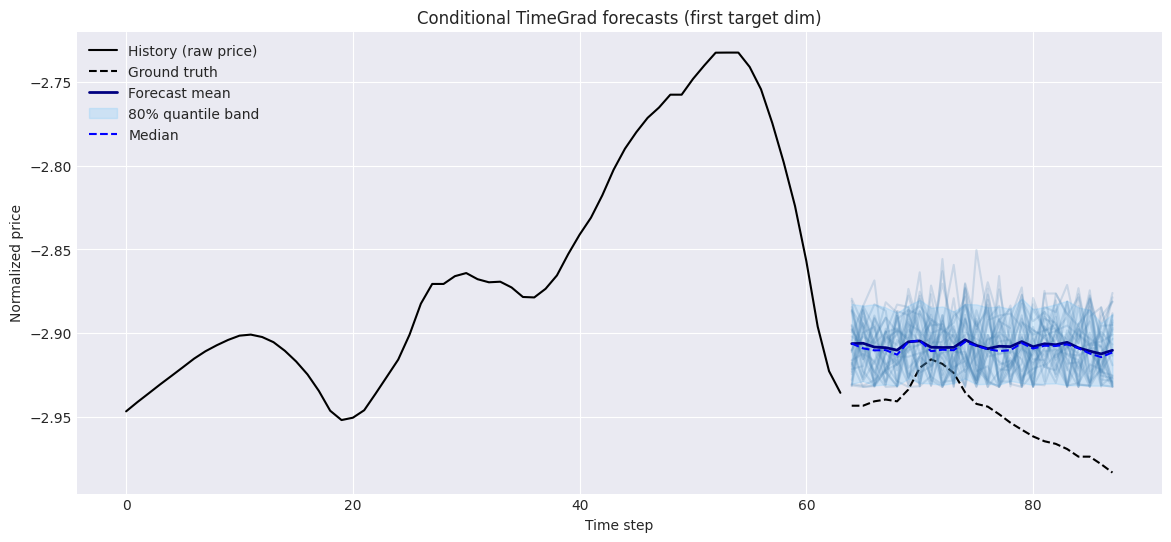

In [14]:
# Plot results for the first series
b = 0
history = x_hist[b].cpu()
ground_truth = first_batch_target[b].cpu()
mean_b = mean_forecast[b].cpu()
q10, q50, q90 = (q[b].cpu() for q in quantiles)

# pick a few sample paths to visualize
sample_paths = samples[:, b].cpu().numpy()
num_plot_paths = min(30, sample_paths.shape[0])

fig, ax = plt.subplots(figsize=(14, 6))

hist_range = range(context_length)
forecast_range = range(context_length, context_length + prediction_length)

target_series = history[:, 0].numpy()
ax.plot(hist_range, target_series, label='History (raw price)', color='black')
ax.plot(forecast_range, ground_truth[:, 0].numpy(), label='Ground truth', color='black', linestyle='--')

for i in range(num_plot_paths):
    ax.plot(forecast_range, sample_paths[i, :, 0], color='steelblue', alpha=0.2)

ax.plot(forecast_range, mean_b[:, 0].numpy(), label='Forecast mean', color='navy', linewidth=2)
ax.fill_between(forecast_range, q10[:, 0].numpy(), q90[:, 0].numpy(), color='lightskyblue', alpha=0.3, label='80% quantile band')
ax.plot(forecast_range, q50[:, 0].numpy(), color='blue', linestyle='--', label='Median')

ax.set_xlabel('Time step')
ax.set_ylabel('Normalized price')
ax.legend(loc='upper left')
ax.set_title('Conditional TimeGrad forecasts (first target dim)')
plt.show()


### Conditioning effects

- The history encoder tokens flow into the cross-attention and FiLM layers, so regime shifts
  (captured in static conditioning) expand the forecast quantile band when volatility rises.
- Dynamic daily/monthly macro signals enter as causal tokens; when they spike, you should observe
  broader scenario dispersion and higher predicted variance.
- The relative positional bias and causal masks keep the autoregressive sampling aligned so
  conditioning only influences future steps through the observed history window.
